## Fitting Min 7-Day Average Flow Data from Russian River Basins to a Pearson-III Distribution Using the Method of Moments to Quantify Extremeness of Years
by Arman Omidvar

Analysis of Low Flows and Selected Methods for Estimating Low-Flow Characteristics at Partial-Record and Ungaged Stream Sites in Western Washington

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import pearson3
import matplotlib.pyplot as plt
from scipy.special import gammaln

In [10]:
def sample_mean(low_flows):
    log_low_flows = np.log10(low_flows)
    return np.mean(log_low_flows)

def sample_std(low_flows):
    log_low_flows = np.log10(low_flows)
    return np.std(log_low_flows, ddof=1)

def sample_skew(low_flows):
    n = len(low_flows)
    log_low_flows = np.log10(low_flows)
    std = np.std(log_low_flows, ddof=1)
    mean = np.mean(log_low_flows)

    return (np.sum((log_low_flows - mean) ** 3) * n) / ((n - 1) * (n - 2) * (std ** 3))

In [11]:
def pearsonIII_alpha_estimate(sample_skew):
    """
    Compute the MOM estimate of the alpha parameter for a Pearson-III distribution based on the weighted skew.
    """
    alpha = (4 / (sample_skew ** 2))
    return alpha

def pearsonIII_beta_estimate(sample_skew, standard_error, alpha_hat):
    """
    Compute the MOM estimate of the beta parameter for a Pearson-III distribution.
    """
    beta_hat = np.sign(sample_skew) * (standard_error ** 2 / alpha_hat) ** 0.5
    return beta_hat

def pearsonIII_tau_estimate(mean_log_peak_flows, beta_hat, alpha_hat):
    """
    Compute the MOM estimate of the tau parameter for a Pearson-III distribution.
    """
    tau_hat = mean_log_peak_flows - (alpha_hat * beta_hat)
    return tau_hat

Basin: Calpella
alpha_hat: 2.080639078500075, beta_hat: -0.3133327978775831, tau_hat: 2.2714504390798838


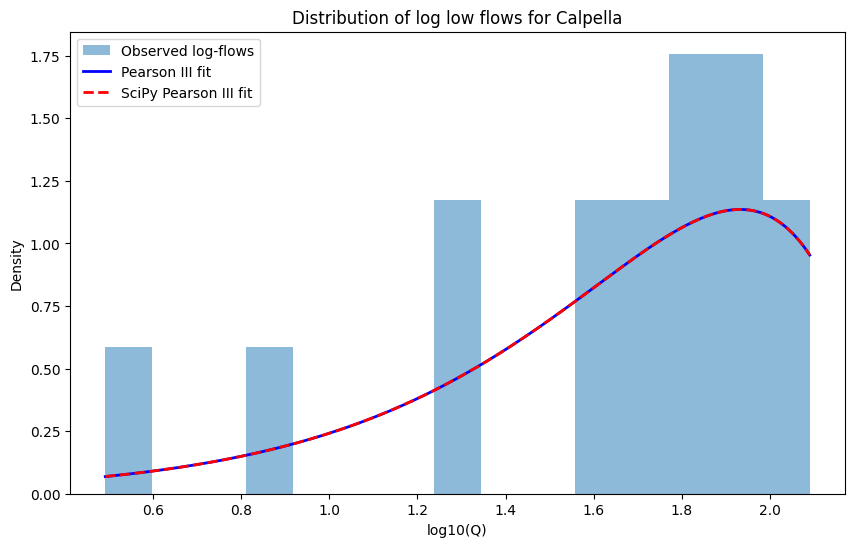

Basin: Guerneville
alpha_hat: 60.20017246455094, beta_hat: -0.011876999805094563, tau_hat: 3.093108817025167


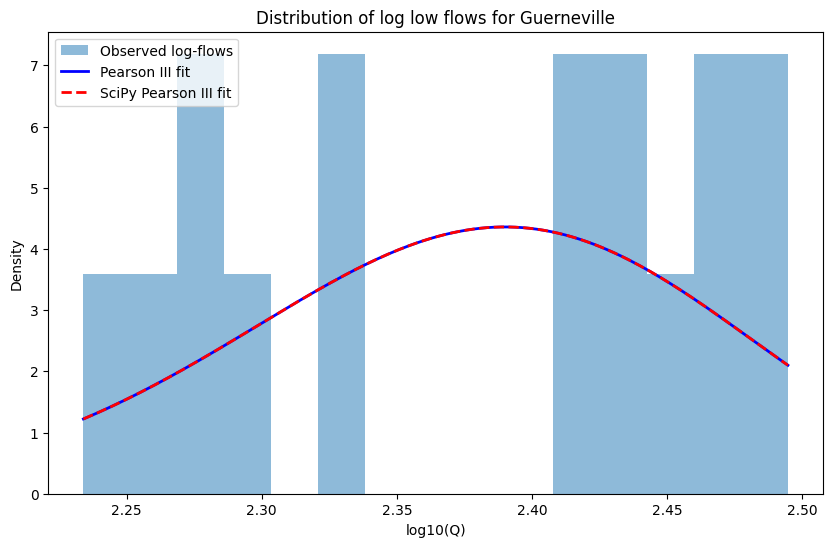

Basin: Hopland
alpha_hat: 143.40522778069376, beta_hat: -0.013502753320983338, tau_hat: 4.020265502804605


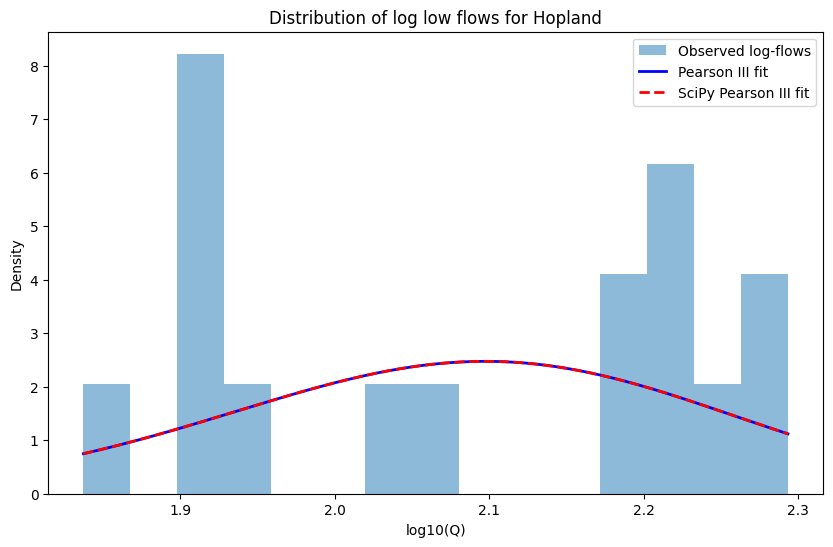

Basin: Warm Springs
alpha_hat: 31.748756531773154, beta_hat: -0.01533941646916614, tau_hat: 2.2440602609702203


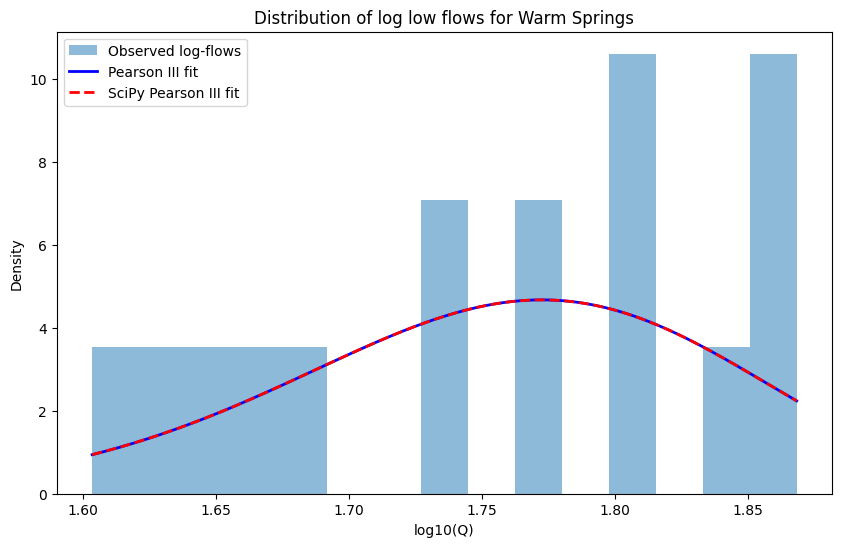

In [ ]:
calpella_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Calpella.csv')
guerneville_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Guerneville.csv')
hopland_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Hopland.csv')
warmsprings_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Warm.csv')

calpella_all_data = pd.read_csv('russian_river_data/Calpella_daily.csv')
guerneville_all_data = pd.read_csv('russian_river_data/Guerneville_daily.csv')
hopland_all_data = pd.read_csv('russian_river_data/Hopland_daily.csv')
warmsprings_all_data = pd.read_csv('russian_river_data/WarmSprings_Inflow_daily.csv')


low_flows = {'Calpella': calpella_low_flows['mav'].values,
              'Guerneville': guerneville_low_flows['mav'].values,
              'Hopland': hopland_low_flows['mav'].values,
              'Warm Springs': warmsprings_low_flows['mav'].values}

all_data = {'Calpella': calpella_all_data,
            'Guerneville': guerneville_all_data,
            'Hopland': hopland_all_data,
            'Warm Springs': warmsprings_all_data}


extreme_years = pd.DataFrame()
extreme_years['climatic_year'] = calpella_low_flows['climatic_year']


def pearson3_pdf(x, alpha, beta, tau):
    x = np.asarray(x, dtype=float)

    if alpha <= 0 or beta == 0:
        return np.full_like(x, np.nan)

    z = (x - tau) / beta
    mask = z > 0

    out = np.zeros_like(x, dtype=float)
    logpdf = -np.log(abs(beta)) - gammaln(alpha) + (alpha - 1)*np.log(z[mask]) - z[mask]
    out[mask] = np.exp(logpdf)
    return out

for basin in low_flows.keys():
    basin_low_flows = low_flows[basin]
    sam_skew = sample_skew(basin_low_flows)

    log_flows = np.log10(basin_low_flows)
    mean_log_flows = np.mean(log_flows)
    std_log_flows = np.std(log_flows, ddof=1)

    alpha_hat = pearsonIII_alpha_estimate(sam_skew)
    beta_hat = pearsonIII_beta_estimate(sam_skew, std_log_flows, alpha_hat)
    tau_hat = pearsonIII_tau_estimate(mean_log_flows, beta_hat, alpha_hat)

    print(f'Basin: {basin}')
    print(f'alpha_hat: {alpha_hat}, beta_hat: {beta_hat}, tau_hat: {tau_hat}')

    dist = pearson3(sam_skew, loc=mean_log_flows, scale=std_log_flows)
    x = np.linspace(min(log_flows), max(log_flows), 200)
    scipy_pdf_vals = dist.pdf(x)
    my_pdf_vals = pearson3_pdf(x, alpha_hat, beta_hat, tau_hat)

    extreme_years[basin] = 1 - dist.cdf(np.log10(basin_low_flows))

    plt.figure(figsize=(10, 6))
    plt.hist(log_flows, bins=15, density=True, alpha=0.5, label='Observed log-flows')
    plt.plot(x, my_pdf_vals, 'b-', lw=2, label='Pearson III fit')
    plt.plot(x, scipy_pdf_vals, 'r--', lw=2, label='SciPy Pearson III fit')
    plt.xlabel('log10(Q)')
    plt.ylabel('Density')
    plt.title(f'Distribution of log low flows for {basin}')
    plt.legend()
    plt.show()

In [13]:
extreme_years.to_csv('low_flow_analysis.csv', index=False)
print(extreme_years)

    water_year  Calpella  Guerneville   Hopland  Warm Springs
0         1995  0.357847     0.908532  0.859755      0.278396
1         1996  0.827083     0.239110  0.197639      0.097726
2         1997  0.100730     0.178232  0.193058      0.090263
3         1998  0.816976     0.734341  0.853745      0.315949
4         1999  0.103089     0.098393  0.102316      0.260799
5         2000  0.540740     0.151012  0.179282      0.191419
6         2001  0.611429     0.360163  0.536276      0.475511
7         2002  0.367189     0.869230  0.827554      0.837726
8         2003  0.538648     0.855988  0.932203      0.908905
9         2004  0.228646     0.097093  0.093993      0.797979
10        2005  0.275039     0.288611  0.294643      0.603039
11        2006  0.282955     0.294294  0.298668      0.651519
12        2007  0.936787     0.319999  0.185885      0.111286
13        2008  0.589859     0.934758  0.868684      0.437101
14        2009  0.974380     0.824746  0.852955      0.892903
15      

In [ ]:
basins = [col for col in extreme_years.columns if col != "climatic_year"]

for basin in basins:
    print(f"\n=== {basin} (lowest → highest extremeness) ===")
    
    ranked = (
        extreme_years[["climatic_year", basin]]
        .sort_values(by=basin, ascending=True)  # lowest = most extreme
        .reset_index(drop=True)
    )
    
    ranked["rank"] = ranked.index + 1
    
    print(ranked[["rank", "climatic_year", basin]])


=== Calpella (lowest → highest extremeness) ===
    rank  water_year  Calpella
0      1        1997  0.100730
1      2        1999  0.103089
2      3        2004  0.228646
3      4        2005  0.275039
4      5        2006  0.282955
5      6        1995  0.357847
6      7        2002  0.367189
7      8        2010  0.414858
8      9        2003  0.538648
9     10        2000  0.540740
10    11        2008  0.589859
11    12        2001  0.611429
12    13        1998  0.816976
13    14        1996  0.827083
14    15        2007  0.936787
15    16        2009  0.974380

=== Guerneville (lowest → highest extremeness) ===
    rank  water_year  Guerneville
0      1        2004     0.097093
1      2        1999     0.098393
2      3        2000     0.151012
3      4        1997     0.178232
4      5        1996     0.239110
5      6        2005     0.288611
6      7        2006     0.294294
7      8        2007     0.319999
8      9        2001     0.360163
9     10        1998     0.73434